# Current State

## Preparation

### Libraries

In [1]:
import pandas as pd
import numpy as np

import glob
import xarray as xr

import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 

from sklearn.linear_model import LinearRegression

from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils.plotting import plot_series

## Data Preparations 

### Canola yield

In [2]:
#read dataframe 
canola_2 = df = pd.read_csv('../data/rm-yields-data.csv', header=0, index_col=0, parse_dates=True)
canola_small = canola_2.iloc[:, [0, 2]].copy()

#cut of first 33 observations (NAs)
canola_small.drop(canola_small.index[:33], inplace=True)

#filter out every observation that contains NAs
canola_filtered = canola_small.groupby('RM').filter(lambda group: not group['Canola'].isnull().any())

# how may districts? 148
num_districts = canola_filtered.groupby('RM').ngroups

#extract only the first district 
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

### Weather Data 

In [3]:
cop_all = xr.open_mfdataset(paths='data/raw_data/*.nc', combine='by_coords')

In [4]:
# use mean of latitude, longitude dims as they only deviate marginally
cop_all.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:    (longitude: 4, latitude: 3, time: 267072)
Coordinates:
  * longitude  (longitude) float32 -101.6 -101.5 -101.4 -101.3
  * latitude   (latitude) float32 49.2 49.1 49.0
  * time       (time) datetime64[ns] 1971-04-01 ... 2022-10-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(5136, 3, 4), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(5136, 3, 4), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-11 10:41:08 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...>

In [5]:
cop_all_centralized = cop_all.mean(dim=['latitude', 'longitude'])

cop_all_centralized.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:  (time: 267072)
Coordinates:
  * time     (time) datetime64[ns] 1971-04-01 ... 2022-10-31T23:00:00
Data variables:
    t2m      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    tp       (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>>

In [6]:
column_to_append = canola_dist1['Canola'].tolist()

dist1_df = cop_all_centralized.to_dataframe()

years = dist1_df.index.year
dist1_df['Canola'] = [column_to_append[year - 1971] for year in years]

dist1_df.head()

,t2m,tp,Canola
time,,,
1971-04-01 00:00:00,267.042023,0.010006,18.0
1971-04-01 01:00:00,266.616119,0.000009,18.0
1971-04-01 02:00:00,266.401428,0.000017,18.0
1971-04-01 03:00:00,266.300446,0.000024,18.0
1971-04-01 04:00:00,266.171661,0.000031,18.0


### Visualization

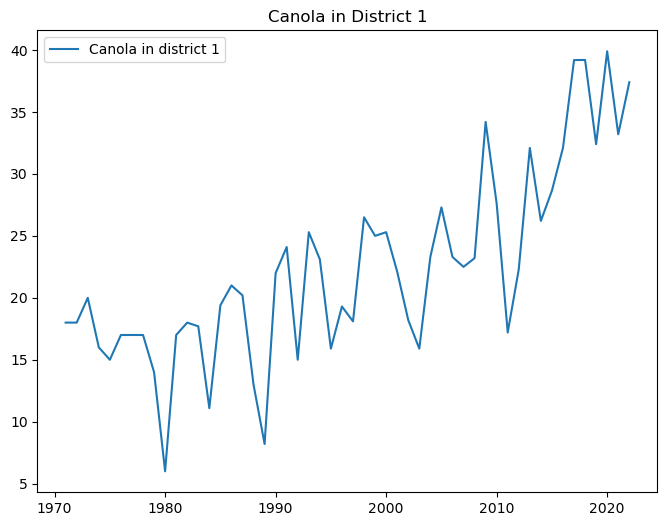

In [7]:
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

plt.figure(figsize=(8, 6))
plt.plot(canola_dist1['Canola'], label=f'Canola in district 1')
plt.title('Canola in District 1')
plt.legend()
plt.show()

### Differencing 

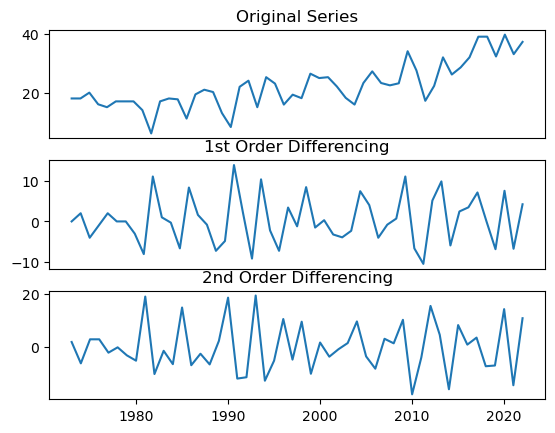

In [8]:
# Differencing Orders (confirms that d is likely 0)
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(canola_dist1.Canola); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(canola_dist1.Canola.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(canola_dist1.Canola.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

### Stationarity 

In [9]:
# Split into test and trainingsdata 

test_set = canola_dist1.iloc[-10:]
training_set = canola_dist1.iloc[:-10]

#check for stationarity with Augmented Dickey-Fuller (ADF) test 

#in the whole dataset
result = adfuller(canola_dist1['Canola'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#in the trainingset
result = adfuller(training_set['Canola'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')



ADF Statistic: 1.5479283723232602
p-value: 0.9976926349856662
ADF Statistic: -3.970425348957505
p-value: 0.0015735410154751842


### Detrending 

<YearEnd: month=12>
ADF Statistic: -6.57329056709387
p-value: 7.838097223650602e-09


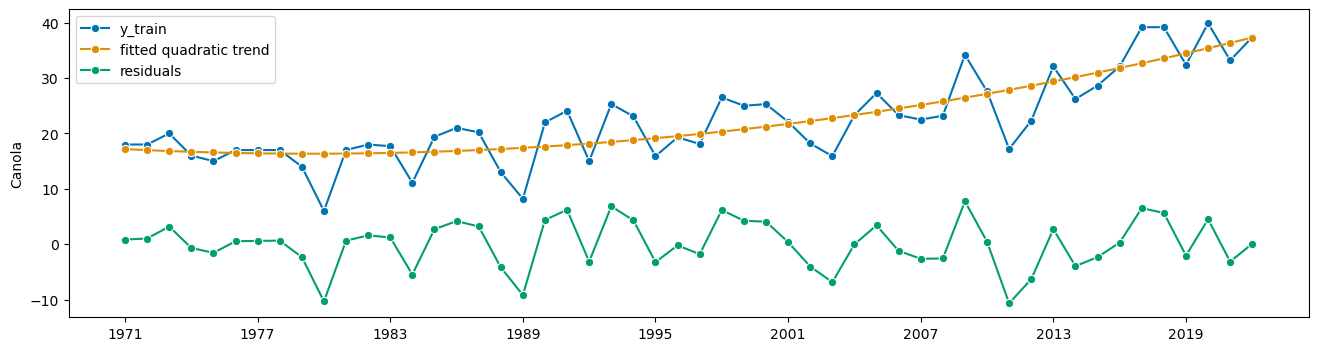

In [10]:
canola_dist1.index = canola_dist1.index.to_period('A')

#change frequency 
frequency = canola_dist1.index.freq

print(frequency)

# linear detrending
forecaster = PolynomialTrendForecaster(degree=2)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(canola_dist1['Canola'])


forecaster = PolynomialTrendForecaster(degree=2)
fh_ins = -np.arange(len(canola_dist1['Canola'])) 
y_pred = forecaster.fit(canola_dist1['Canola']).predict(fh=fh_ins)

plot_series(canola_dist1['Canola'], y_pred, yt, labels=["y_train", "fitted quadratic trend", "residuals"]);

residuals = yt

#ADF 
result = adfuller(residuals)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


In [31]:
# add detrended time series to dataframe 
canola_dist1.loc[:,'Canola_detrend'] = yt

canola_dist1.head()

,RM,Canola,Canola_detrend,average_temp_in_year,average_temp_in_4,average_temp_in_5,average_temp_in_6,average_temp_in_7,average_temp_in_8,average_temp_in_9,...,hot_days_in_7,hot_days_in_8,precipitation_in_year,precipitation_in_4,precipitation_in_5,precipitation_in_6,precipitation_in_7,precipitation_in_8,precipitation_in_9,precipitation_in_10
1971,1,18.0,0.835685,285.822937,276.701538,283.854309,289.748718,290.672729,293.979156,286.152252,...,1,16,6.463214,1.118805,0.942516,1.943965,0.370972,0.438046,0.853838,0.795073
1972,1,18.0,1.019651,285.253143,275.824646,285.927246,290.569458,290.008667,292.916992,284.534332,...,0,9,4.275492,0.565271,0.879331,0.934257,0.648283,0.549492,0.488354,0.210504
1973,1,20.0,3.180447,286.780853,277.133759,284.741882,290.786469,292.997559,294.354370,285.549774,...,4,10,7.338737,0.553545,0.614124,1.337972,0.942960,1.015625,2.248300,0.626210
1974,1,16.0,-0.681926,285.641998,275.509277,281.658173,290.150146,295.285004,290.413635,284.899323,...,6,3,4.385952,0.729882,1.535453,0.490678,0.587174,0.750434,0.187829,0.104502
1975,1,15.0,-1.567468,285.024506,272.058929,283.596344,289.199188,295.075470,290.203400,285.181213,...,8,0,8.166986,1.380962,0.545885,1.909195,0.996213,1.633090,0.954209,0.747434


In [12]:
dist1_df.head()

,t2m,tp,Canola
time,,,
1971-04-01 00:00:00,267.042023,0.010006,18.0
1971-04-01 01:00:00,266.616119,0.000009,18.0
1971-04-01 02:00:00,266.401428,0.000017,18.0
1971-04-01 03:00:00,266.300446,0.000024,18.0
1971-04-01 04:00:00,266.171661,0.000031,18.0


# Feature Extraction 

### Average Temperature

In [32]:
# get average temperature annual

dist1_df_annual = dist1_df.resample('A').mean()
dist1_df_annual.head()

column_to_append = dist1_df_annual['t2m'].tolist()
canola_dist1.loc[:,'average_temp_in_year'] = column_to_append

canola_dist1.head()

,RM,Canola,Canola_detrend,average_temp_in_year,average_temp_in_4,average_temp_in_5,average_temp_in_6,average_temp_in_7,average_temp_in_8,average_temp_in_9,...,hot_days_in_7,hot_days_in_8,precipitation_in_year,precipitation_in_4,precipitation_in_5,precipitation_in_6,precipitation_in_7,precipitation_in_8,precipitation_in_9,precipitation_in_10
1971,1,18.0,0.835685,285.822937,276.701538,283.854309,289.748718,290.672729,293.979156,286.152252,...,1,16,6.463214,1.118805,0.942516,1.943965,0.370972,0.438046,0.853838,0.795073
1972,1,18.0,1.019651,285.253143,275.824646,285.927246,290.569458,290.008667,292.916992,284.534332,...,0,9,4.275492,0.565271,0.879331,0.934257,0.648283,0.549492,0.488354,0.210504
1973,1,20.0,3.180447,286.780853,277.133759,284.741882,290.786469,292.997559,294.354370,285.549774,...,4,10,7.338737,0.553545,0.614124,1.337972,0.942960,1.015625,2.248300,0.626210
1974,1,16.0,-0.681926,285.641998,275.509277,281.658173,290.150146,295.285004,290.413635,284.899323,...,6,3,4.385952,0.729882,1.535453,0.490678,0.587174,0.750434,0.187829,0.104502
1975,1,15.0,-1.567468,285.024506,272.058929,283.596344,289.199188,295.075470,290.203400,285.181213,...,8,0,8.166986,1.380962,0.545885,1.909195,0.996213,1.633090,0.954209,0.747434


In [33]:
# average temperature in one month 

for month in range(4,11):
    
    dist1_df_month = dist1_df.resample('MS').mean()
    month_data = dist1_df_month[dist1_df_month.index.month == month]

    column_to_append = month_data['t2m'].tolist()
    canola_dist1.loc[:, f'average_temp_in_{month}'] = column_to_append

canola_dist1.head()

,RM,Canola,Canola_detrend,average_temp_in_year,average_temp_in_4,average_temp_in_5,average_temp_in_6,average_temp_in_7,average_temp_in_8,average_temp_in_9,...,hot_days_in_7,hot_days_in_8,precipitation_in_year,precipitation_in_4,precipitation_in_5,precipitation_in_6,precipitation_in_7,precipitation_in_8,precipitation_in_9,precipitation_in_10
1971,1,18.0,0.835685,285.822937,276.701538,283.854309,289.748718,290.672729,293.979156,286.152252,...,1,16,6.463214,1.118805,0.942516,1.943965,0.370972,0.438046,0.853838,0.795073
1972,1,18.0,1.019651,285.253143,275.824646,285.927246,290.569458,290.008667,292.916992,284.534332,...,0,9,4.275492,0.565271,0.879331,0.934257,0.648283,0.549492,0.488354,0.210504
1973,1,20.0,3.180447,286.780853,277.133759,284.741882,290.786469,292.997559,294.354370,285.549774,...,4,10,7.338737,0.553545,0.614124,1.337972,0.942960,1.015625,2.248300,0.626210
1974,1,16.0,-0.681926,285.641998,275.509277,281.658173,290.150146,295.285004,290.413635,284.899323,...,6,3,4.385952,0.729882,1.535453,0.490678,0.587174,0.750434,0.187829,0.104502
1975,1,15.0,-1.567468,285.024506,272.058929,283.596344,289.199188,295.075470,290.203400,285.181213,...,8,0,8.166986,1.380962,0.545885,1.909195,0.996213,1.633090,0.954209,0.747434


In [15]:
dist1_df.head()

,t2m,tp,Canola
time,,,
1971-04-01 00:00:00,267.042023,0.010006,18.0
1971-04-01 01:00:00,266.616119,0.000009,18.0
1971-04-01 02:00:00,266.401428,0.000017,18.0
1971-04-01 03:00:00,266.300446,0.000024,18.0
1971-04-01 04:00:00,266.171661,0.000031,18.0


### Number of hot days 

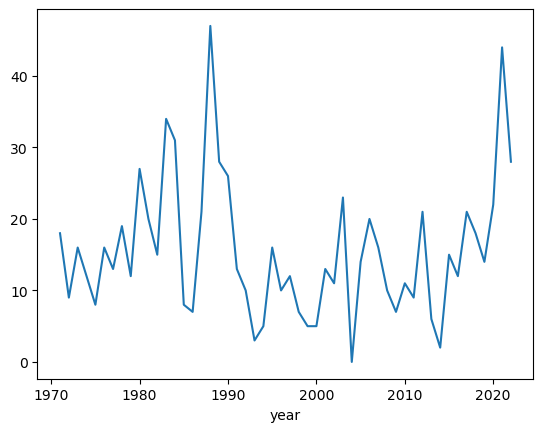

C:\Users\maris\AppData\Local\Temp\ipykernel_27272\3393256023.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1['hot_days_in_year'] = column_to_append


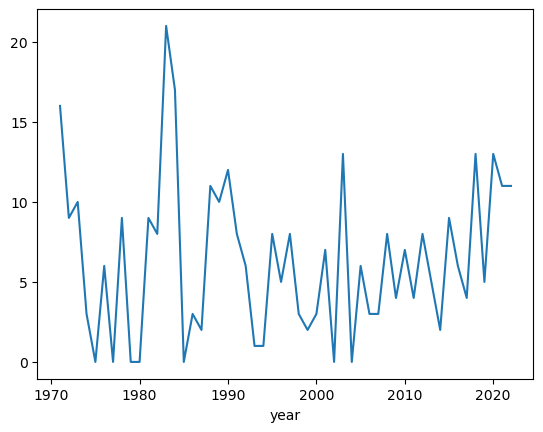

      RM  Canola  Canola_detrend  average_temp_in_year  average_temp_in_4  \
1971   1    18.0        0.835685            285.822937         276.701538   
1972   1    18.0        1.019651            285.253143         275.824646   
1973   1    20.0        3.180447            286.780853         277.133759   
1974   1    16.0       -0.681926            285.641998         275.509277   
1975   1    15.0       -1.567468            285.024506         272.058929   

      average_temp_in_5  average_temp_in_6  average_temp_in_7  \
1971         283.854309         289.748718         290.672729   
1972         285.927246         290.569458         290.008667   
1973         284.741882         290.786469         292.997559   
1974         281.658173         290.150146         295.285004   
1975         283.596344         289.199188         295.075470   

      average_temp_in_8  average_temp_in_9  ...  hot_days_in_7  hot_days_in_8  \
1971         293.979156         286.152252  ...              1   

In [36]:
#hot days in one year 
dist1_df_hot = dist1_df 

# add extra columns containing the years and the months
dist1_df_hot['year'] = dist1_df_hot.index.year
dist1_df_hot['month'] = dist1_df_hot.index.month

# get variables year, month and canola from old data frame 
daily_df = dist1_df.resample('D').first()
daily_df = daily_df[["Canola","year","month"]]

# Resample the data to daily frequency and get the maximum temperature for each day
daily_max_temperature = dist1_df_hot['t2m'].resample('D').max()

# add max temp per day to data frame
daily_df['max_temp'] = daily_max_temperature

# count hot days per year 
hot_days_by_year = daily_df[daily_df["max_temp"] > 303].groupby('year').size()

hot_days_by_year = hot_days_by_year.reindex(range(dist1_df_hot['year'].min(), dist1_df_hot['year'].max() + 1), fill_value=0)

hot_days_by_year.plot()

plt.show()

#append hot da
column_to_append = hot_days_by_year.tolist()
canola_dist1.loc[:,'hot_days_in_year'] = column_to_append

august_data = daily_df[daily_df['month'] == 8]

# hot days per year in August
hot_days_in_august_by_year = august_data[august_data["max_temp"] > 303].groupby('year').size()

#keep years with 0 days over 30 degrees in the dataframe 
hot_days_in_august_by_year = hot_days_in_august_by_year.reindex(range(dist1_df_hot['year'].min(), dist1_df_hot['year'].max() + 1), fill_value=0)

hot_days_in_august_by_year.head()

hot_days_in_august_by_year.plot()

plt.show()

hot_days_by_month_df = daily_df

# get number of hot days per month from may til august
for month in range(5, 9):
    # Filter data for the current month
    month_data = daily_df[daily_df['month'] == month]

    # hot days per year in the current month
    hot_days_by_month = month_data[month_data["max_temp"] > 303].groupby('year').size()

    # Reindex to include all years and fill NaN values with 0
    hot_days_by_month = hot_days_by_month.reindex(range(dist1_df_hot['year'].min(), dist1_df_hot['year'].max() + 1), fill_value=0)

    
    # append column to dataframe  
    column_to_append = hot_days_by_month.tolist()
    canola_dist1.loc[:,f'hot_days_in_{month}'] = column_to_append


# Display the common data frame
print(canola_dist1.head())




### Precipitation in one year/month

In [35]:
#percipitation in one year 
dist1_df_precipitation = dist1_df.resample('A').sum()
dist1_df_precipitation.head()

column_to_append = dist1_df_precipitation['tp'].tolist()
canola_dist1.loc[:,'precipitation_in_year'] = column_to_append

#percipitation in one month in one year

for month in range(4,11):
    
    dist1_df_month = dist1_df.resample('MS').sum()
    month_data = dist1_df_month[dist1_df_month.index.month == month]
    
    column_to_append = month_data['tp'].tolist()
    canola_dist1.loc[:,f'precipitation_in_{month}'] = column_to_append

canola_dist1.head()


,RM,Canola,Canola_detrend,average_temp_in_year,average_temp_in_4,average_temp_in_5,average_temp_in_6,average_temp_in_7,average_temp_in_8,average_temp_in_9,...,hot_days_in_7,hot_days_in_8,precipitation_in_year,precipitation_in_4,precipitation_in_5,precipitation_in_6,precipitation_in_7,precipitation_in_8,precipitation_in_9,precipitation_in_10
1971,1,18.0,0.835685,285.822937,276.701538,283.854309,289.748718,290.672729,293.979156,286.152252,...,1,16,6.463214,1.118805,0.942516,1.943965,0.370972,0.438046,0.853838,0.795073
1972,1,18.0,1.019651,285.253143,275.824646,285.927246,290.569458,290.008667,292.916992,284.534332,...,0,9,4.275492,0.565271,0.879331,0.934257,0.648283,0.549492,0.488354,0.210504
1973,1,20.0,3.180447,286.780853,277.133759,284.741882,290.786469,292.997559,294.354370,285.549774,...,4,10,7.338737,0.553545,0.614124,1.337972,0.942960,1.015625,2.248300,0.626210
1974,1,16.0,-0.681926,285.641998,275.509277,281.658173,290.150146,295.285004,290.413635,284.899323,...,6,3,4.385952,0.729882,1.535453,0.490678,0.587174,0.750434,0.187829,0.104502
1975,1,15.0,-1.567468,285.024506,272.058929,283.596344,289.199188,295.075470,290.203400,285.181213,...,8,0,8.166986,1.380962,0.545885,1.909195,0.996213,1.633090,0.954209,0.747434


### Linear Regression model 

                  hot_days_in_year
hot_days_in_year               1.0
                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.994
Date:                Sun, 14 Jan 2024   Prob (F-statistic):             0.0179
Time:                        23:22:30   Log-Likelihood:                -146.66
No. Observations:                  52   AIC:                             297.3
Df Residuals:                      50   BIC:                             301.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

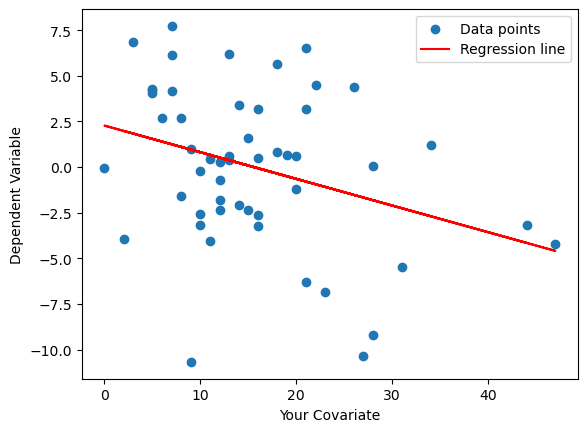

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Regression for one covariate 
canola_lr = canola_dist1.iloc[:, 2:]

y = canola_lr.iloc[:, 0] 
X = canola_lr[["hot_days_in_year"]]

correlation_matrix = X.corr()
print(correlation_matrix)

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

plt.scatter(canola_lr[["hot_days_in_year"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["hot_days_in_year"]], results.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Your Covariate')
plt.ylabel('Dependent Variable')
plt.legend()

# Show the plot
plt.show()

In [20]:
#linear regression using all covariates 

y = canola_lr.iloc[:, 0] 
X = canola_lr.iloc[:, 1:] 

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

# non of the effects are significant -> multicollianrity? 

#correlation matrix
correlation_matrix = X.corr()
print(correlation_matrix)

#VIF Test 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.116
Date:                Sun, 14 Jan 2024   Prob (F-statistic):              0.384
Time:                        23:22:30   Log-Likelihood:                -134.59
No. Observations:                  52   AIC:                             313.2
Df Residuals:                      30   BIC:                             356.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   164.29

### Simple linear Regression model 

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     9.425
Date:                Sun, 14 Jan 2024   Prob (F-statistic):            0.00346
Time:                        23:22:30   Log-Likelihood:                -145.11
No. Observations:                  52   AIC:                             294.2
Df Residuals:                      50   BIC:                             298.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8868      0.830      2.274

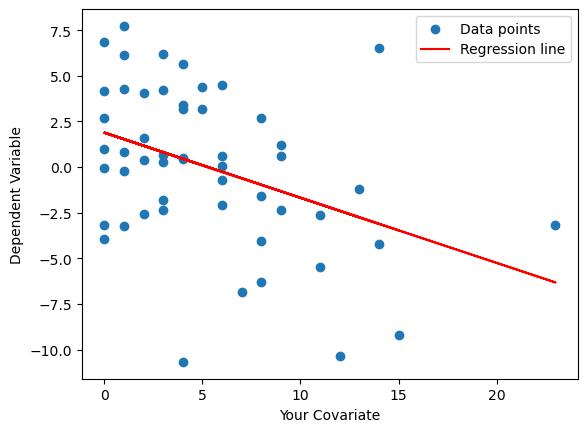

In [21]:
# Hot days in july

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["hot_days_in_7"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["hot_days_in_7"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["hot_days_in_7"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Your Covariate')
plt.ylabel('Dependent Variable')
plt.legend()

# Show the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.994
Date:                Sun, 14 Jan 2024   Prob (F-statistic):             0.0179
Time:                        23:22:30   Log-Likelihood:                -146.66
No. Observations:                  52   AIC:                             297.3
Df Residuals:                      50   BIC:                             301.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2762      1.093  

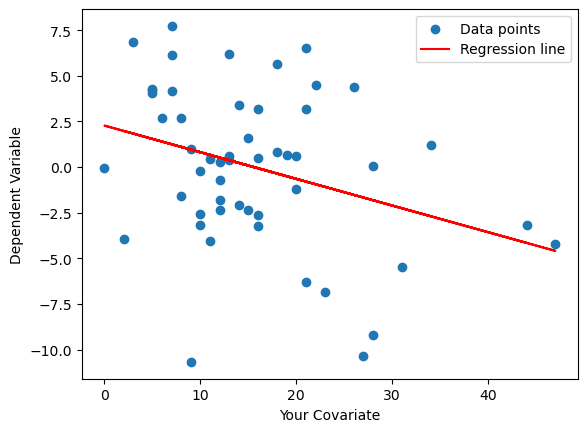

In [22]:
# Hot days in year

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["hot_days_in_year"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["hot_days_in_year"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["hot_days_in_year"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Your Covariate')
plt.ylabel('Dependent Variable')
plt.legend()

# Show the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     10.03
Date:                Sun, 14 Jan 2024   Prob (F-statistic):            0.00262
Time:                        23:22:31   Log-Likelihood:                -144.85
No. Observations:                  52   AIC:                             293.7
Df Residuals:                      50   BIC:                             297.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               313.9088     99.10

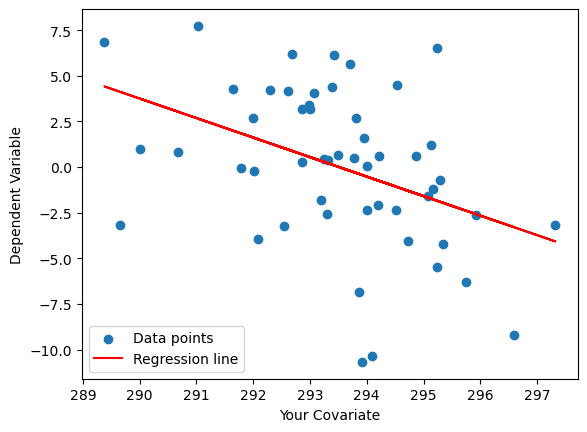

In [23]:
# average temp in july 

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["average_temp_in_7"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["average_temp_in_7"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["average_temp_in_7"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Your Covariate')
plt.ylabel('Dependent Variable')
plt.legend()

# Show the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:         Canola_detrend   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     4.713
Date:                Sun, 14 Jan 2024   Prob (F-statistic):             0.0347
Time:                        23:22:31   Log-Likelihood:                -147.26
No. Observations:                  52   AIC:                             298.5
Df Residuals:                      50   BIC:                             302.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3664      1

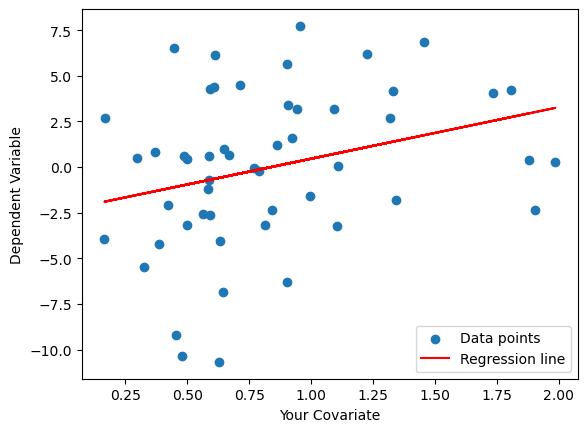

In [24]:
# percipitation in july

y = canola_lr.iloc[:, 0] 
X_1 = canola_lr[["precipitation_in_7"]]

X_1 = sm.add_constant(X_1)

model = sm.OLS(y, X_1)
results_one = model.fit()

print(results_one.summary())

plt.scatter(canola_lr[["precipitation_in_7"]], canola_lr[["Canola_detrend"]], label='Data points')

# Plot the regression line
plt.plot(canola_lr[["precipitation_in_7"]], results_one.predict(), color='red', label='Regression line')

# Add labels and a legend
plt.xlabel('Your Covariate')
plt.ylabel('Dependent Variable')
plt.legend()

# Show the plot
plt.show()

### ARIMA 

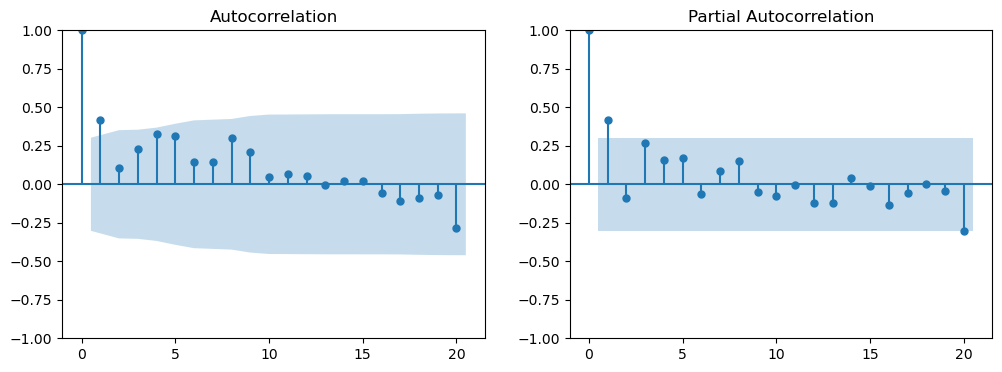

In [25]:
# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(training_set['Canola'], lags=20, ax=ax1) # p = 1
plot_pacf(training_set['Canola'], lags=20, ax=ax2) # q = 1

plt.show()


C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Canola   No. Observations:                   42
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -123.138
Date:                Sun, 14 Jan 2024   AIC                            250.275
Time:                        23:22:31   BIC                            253.702
Sample:                    01-01-1971   HQIC                           251.523
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8045      0.106     -7.591      0.000      -1.012      -0.597
sigma2        23.1829      5.550      4.177      0.000      12.305      34.060
Ljung-Box (L1) (Q):                   0.61   Jarque-

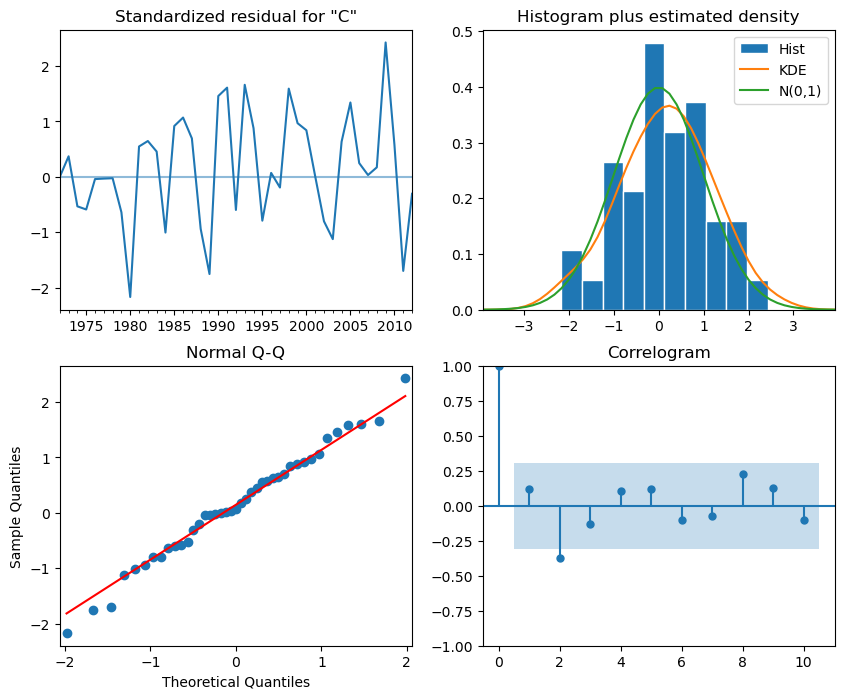

In [26]:
#fit model 

p, d, q = (0, 1, 1)
model = ARIMA(training_set['Canola'], order=(p, d, q), freq = "AS-JAN")
results = model.fit()

# Print model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(10, 8))
plt.show()

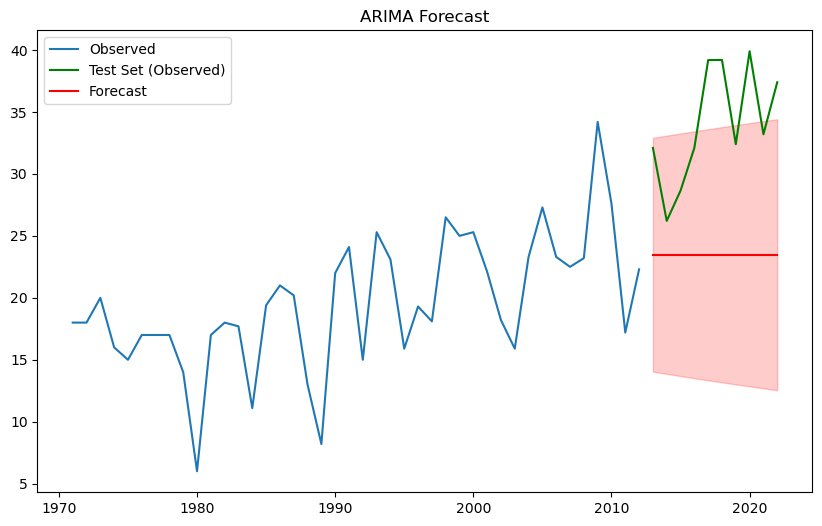

In [27]:
#forecastingt 

forecast_steps = 10 
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

forecast_start_date = training_set.index[-1] + pd.DateOffset(years=1)
forecast_end_date = forecast.predicted_mean.index[-1]
full_index = pd.date_range(start=training_set.index[0], end=forecast_end_date, freq='AS-JAN')
forecast.predicted_mean = forecast.predicted_mean.reindex(full_index, fill_value=None)

plt.figure(figsize=(10, 6))
plt.plot(training_set['Canola'], label='Observed')
plt.plot(test_set.index, test_set['Canola'], label='Test Set (Observed)', color='green')
plt.plot(forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

### Exponential Smoothing 

In [28]:
alpha_star = None
best_mse = None
dat = canola_dist1.iloc[:, :].values.astype('float32')
mean_results_for_all_possible_alpha_values = np.zeros(9)
for alpha in range(0, 9):
    pt = np.mean(dat[:, 0][0:5])
    mean_for_alpha = np.zeros(len(dat))
    mean_for_alpha[0] = np.power(dat[0][0] - pt, 2)
    for i in range(1, len(dat)):
        pt = pt + ((alpha + 1) * 0.1) * (dat[i - 1][0] - pt)
        mean_for_alpha[i] = np.power(dat[i][0] - pt, 2)
    mean_results_for_all_possible_alpha_values[alpha] = np.mean(mean_for_alpha)
alpha_star = (np.argmin(mean_results_for_all_possible_alpha_values) + 1) * 0.1
best_mse = np.min(mean_results_for_all_possible_alpha_values)
print("Best MSE = %s" % best_mse)
print("Optimal alpha = %s" % alpha_star)

Best MSE = 0.0
Optimal alpha = 0.1


In [29]:
model3 = SimpleExpSmoothing(training_set['Canola'])
model3_fit = model3.fit(smoothing_level=0.1,optimized=False)
model3_fit.params
y_hat_ses = test_set.copy()
y_hat_ses['ses_forecast'] = model3_fit.forecast(len(test_set))

print(y_hat_ses['ses_forecast'])

Year
2013-01-01    22.554573
2014-01-01    22.554573
2015-01-01    22.554573
2016-01-01    22.554573
2017-01-01    22.554573
2018-01-01    22.554573
2019-01-01    22.554573
2020-01-01    22.554573
2021-01-01    22.554573
2022-01-01    22.554573
Name: ses_forecast, dtype: float64


C:\Users\maris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


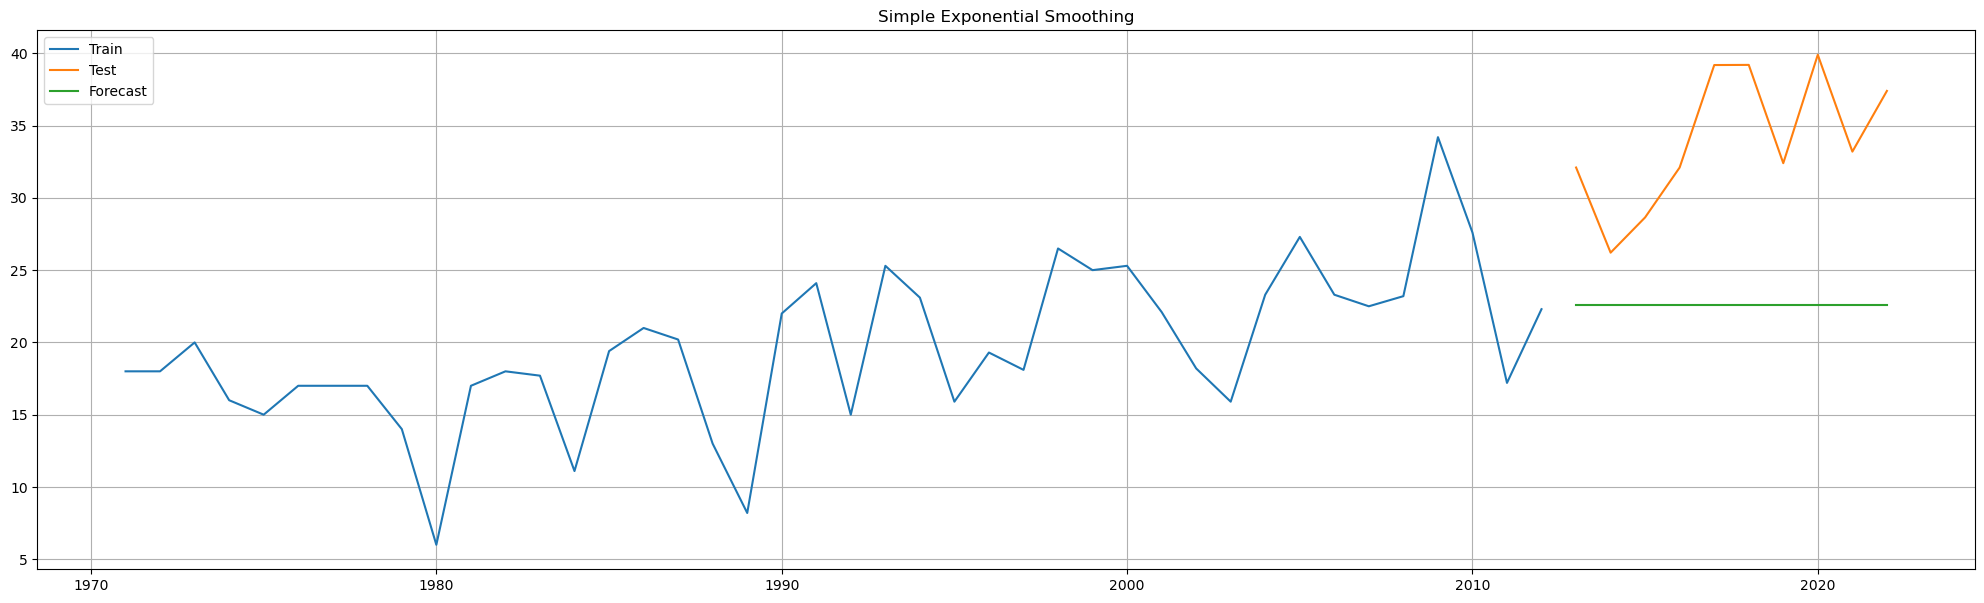

In [30]:
plt.figure(figsize=(25,7))
plt.grid()
plt.plot(training_set['Canola'], label='Train')
plt.plot(test_set['Canola'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing')
plt.show()